In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

In [2]:
#Generate a toy dataset to check the algorithm

m = 10 # half number of samples
n = 3 # number of features

x1 = np.random.rand(m,n+1)
x1[:,0] *= 3
x1[:, -1] = 1

x2 = np.random.randn(m,n+1)
x2[:, -1] = 0

Xt = np.vstack((x1, x2))

In [3]:
# Shuffle the toy dataset
np.random.shuffle(Xt)
Xt[:10]

array([[-0.88778575, -1.98079647, -0.34791215,  0.        ],
       [ 0.17742614, -0.40178094, -1.63019835,  0.        ],
       [ 0.06651722,  0.3024719 , -0.63432209,  0.        ],
       [ 1.2709644 ,  0.64589411,  0.43758721,  1.        ],
       [ 2.93585503,  0.79915856,  0.46147936,  1.        ],
       [ 1.56554497,  0.41466194,  0.26455561,  1.        ],
       [ 0.06065519,  0.83261985,  0.77815675,  1.        ],
       [-0.67246045, -0.35955316, -0.81314628,  0.        ],
       [ 1.83628717,  0.616934  ,  0.94374808,  1.        ],
       [-0.51080514, -1.18063218, -0.02818223,  0.        ]])

In [4]:
# Separate the features and labels
X0 = Xt[:,:-1] # m samples with n features
y0 = Xt[:,-1] # binary label for m samples

In [5]:
print(X0.shape, y0.shape)

(20, 3) (20,)


In [6]:
class nn:
    '''This is a class that implements a simple two layer dense neural network for binary classification.'''
    '''n_nerurons is a list of number of perceptrons in each layer.'''
    '''n_neurons list starts with the first hidden layer and ends with the output'''
    
    def __init__(self, threshold=0.5, lr=0.01, n_neurons=[4]):
        self.threshold = threshold
        self.lr = lr
        self.n_neurons = n_neurons
    
    def initiate_params(self, X, n_neurons):
        # Function to initiate weights and bias for all layers as a dictionary
        m, n = X.shape
        params = {}
        i = 0
        while i < len(n_neurons):
            if i == 0:
                params['W' + str(i)] = np.random.randn(n_neurons[i], n) * 0.01
            else:
                params['W' + str(i)] = np.random.randn(n_neurons[i], n_neurons[i-1])
            params['b' + str(i)] = np.ones((n_neurons[i], 1))
#             print('W', str(i), ": ", params['W' + str(i)].shape)
#             print('b', str(i), ": ", params['b' + str(i)].shape)
            i += 1
        return params
    
    def sigmoid(self, Z):
        # Function for sigmoid activation
        A = 1 / (1 + np.exp(-Z))
        return A
    
    def forward_prop(self, X, params):
        # This function will perform one pass of forward propogation
        activations = {}
        
        for i in range(len(self.n_neurons)):
            if i == 0:
                Z = np.dot(params['W' + str(i)], X) + params['b' + str(i)]
            else:
                Z = np.dot(params['W' + str(i)], activations['A' + str(i-1)]) + params['b' + str(i)]
            activations['Z' + str(i)] = Z
            activations['A' + str(i)] = self.sigmoid(Z)
#             print("A", str(i), ": ", activations['A' + str(i)].shape)
        return activations
    
    def final_result(self, y, A):
        # This function will produce the yhat converted based on threshhold and calculate accuracy
        mask0 = A <= self.threshold
        mask1 = A > self.threshold
        yhat = A.copy()
        yhat[mask0] = 0
        yhat[mask1] = 1
        
        # Add each accuracy to a list for plotting
        acc = np.sum((1 - abs(y - A)) * 100)/y.shape[1]
        print("Accuracy: ", acc)
        self.accuracy.append(acc)
        return (yhat)
    
    def back_prop(self, X, y, m, params, activations):
        # This function will perform one pass of backward propogation
        gradients = {}
        i = len(self.n_neurons) - 1
        while i >= 0:
            if i == len(self.n_neurons) - 1:
                # back prop for final layer
                dZ = y - activations['A' + str(i)]                                           # dJ/dZ = y_pred - y
                dW = np.dot(dZ, activations['A' + str(i-1)].T)/m                             # dJ/dW = X * dJ/dZ
                db = (np.sum(dZ, keepdims=True))/m                                           # dJ/db = sum of dJ/dZ
            elif i == 0:
                # back prop for first hidden layer
                act = activations['A' + str(i)] * (1 - activations['A' + str(i)])            # calculate A * (1-A)
                dZ = np.dot(params['W' + str(i+1)].T, gradients['dZ' + str(i+1)]) * act       # dJ/dZ = dJ/dA * dA/dZ
                dW = np.dot(dZ, X.T)/m                                                       # dJ/dW = X * dJ/dZ
                db = (np.sum(dZ, axis=1, keepdims=True))/m                                   # dJ/db = sum of dJ/dZ
            else:
                # back prop for all other intermediate layers
                act = activations['A' + str(i)] * (1 - activations['A' + str(i)])            # calculate A * (1-A)
                dZ = np.dot(params['W' + str(i+1)].T, gradients['dZ' + str(i+1)]) * act       # dJ/dZ = dJ/dA * dA/dZ
                dW = np.dot(dZ, activations['A' + str(i-1)].T)/m                             # dJ/dW = prev_A * dJ/dZ
                db = (np.sum(dZ, axis=1, keepdims=True))/m                                   # dJ/db = sum of dJ/dZ
            
            gradients['dZ' + str(i)] = dZ
            gradients['dW' + str(i)] = dW
            gradients['db' + str(i)] = db
#             print('dZ', str(i), ": ", gradients['dZ' + str(i)].shape)
#             print('dW', str(i), ": ", gradients['dW' + str(i)].shape)
#             print('db', str(i), ": ", gradients['db' + str(i)].shape)
            i -= 1
        return gradients
        
    def fit(self, X, y, epochs=10):
        # This function will repeat forward and backward propogation many times 
        self.params = self.initiate_params(X, self.n_neurons) # initiate weights and bias for all layers
        
        self.activations = {}
        self.gradients = {}
        
        self.loss = []
        self.accuracy = []
        
        X = X.T                                               # transpose X to (n,m) for easy operation
        n, m = X.shape
        y = y.reshape((1, m))                                 # transpose and reshape y to make it order 2 array
        
        for i in range(epochs):
            print("Epoch ", i+1, " of ", epochs)
            self.activations = self.forward_prop(X, self.params)
            
            y_pred = self.activations['A' + str(len(self.n_neurons)-1)]
            
            yhat = self.final_result(y, y_pred)
            
            J = -np.sum((y*np.log(y_pred)) + ((1 - y)*np.log(1 - y_pred)))/m # loss function
            print("Loss: ", J)
            self.loss.append(J)                                      # add each accuracy to a list for plotting
            
            self.gradients = self.back_prop(X=X, y=y, m=m, params=self.params, activations=self.activations)
            
            for j in range(len(self.n_neurons)):
                self.params['W' + str(j)] += self.lr * self.gradients['dW' + str(j)]   # update hidden layer weights
                self.params['b' + str(j)] += self.lr * self.gradients['db' + str(j)]   # update hidden layer bias
        print("Forward and backward propogation competed for {} iterations!".format(epochs))
        print("Predicted Output \n", yhat)
 
    def show_plot(self):
        # This function is used to plot the learning history
        plt.figure(figsize=(15,5))
        print("Model Performance Plots")
        
        # Subplot for loss vs number of iterations
        plt.subplot(1,2,1)
        plt.grid(axis='both')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        sns.lineplot(x=range(len(self.loss)), y=self.loss)
        
        # Subplot for accuracy vs number of iterations
        plt.subplot(1,2,2)
        plt.grid(axis='both')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        sns.lineplot(x=range(len(self.accuracy)), y=self.accuracy)
        plt.show()

In [7]:
model = nn(lr=0.1, n_neurons=[4,3,2,1])

In [8]:
model.fit(X0, y0, epochs=2500)

Epoch  1  of  2500
Accuracy:  49.99698901987643
Loss:  0.7107974967353575
Epoch  2  of  2500
Accuracy:  49.99715234949633
Loss:  0.7090599366232142
Epoch  3  of  2500
Accuracy:  49.99732871024766
Loss:  0.7074894635471246
Epoch  4  of  2500
Accuracy:  49.99751738549274
Loss:  0.7060705635855185
Epoch  5  of  2500
Accuracy:  49.9977176793691
Loss:  0.7047890563133841
Epoch  6  of  2500
Accuracy:  49.997928919730285
Loss:  0.7036319989236974
Epoch  7  of  2500
Accuracy:  49.998150460277664
Loss:  0.7025875938174558
Epoch  8  of  2500
Accuracy:  49.998381682007405
Loss:  0.7016451002513832
Epoch  9  of  2500
Accuracy:  49.99862199408442
Loss:  0.7007947504451485
Epoch  10  of  2500
Accuracy:  49.99887083424311
Loss:  0.7000276703952467
Epoch  11  of  2500
Accuracy:  49.999127668802565
Loss:  0.699335805516803
Epoch  12  of  2500
Accuracy:  49.99939199237208
Loss:  0.698711851133888
Epoch  13  of  2500
Accuracy:  49.99966332731248
Loss:  0.698149187759915
Epoch  14  of  2500
Accuracy:  49.

Epoch  119  of  2500
Accuracy:  50.03806365845509
Loss:  0.6923863531488089
Epoch  120  of  2500
Accuracy:  50.03845336562432
Loss:  0.6923785730922969
Epoch  121  of  2500
Accuracy:  50.03884354754283
Loss:  0.6923707840306734
Epoch  122  of  2500
Accuracy:  50.03923420927073
Loss:  0.6923629858096221
Epoch  123  of  2500
Accuracy:  50.03962535587712
Loss:  0.6923551782808136
Epoch  124  of  2500
Accuracy:  50.04001699243948
Loss:  0.6923473613012703
Epoch  125  of  2500
Accuracy:  50.04040912404325
Loss:  0.6923395347327933
Epoch  126  of  2500
Accuracy:  50.040801755781395
Loss:  0.6923316984414494
Epoch  127  of  2500
Accuracy:  50.041194892754106
Loss:  0.6923238522971094
Epoch  128  of  2500
Accuracy:  50.04158854006853
Loss:  0.6923159961730321
Epoch  129  of  2500
Accuracy:  50.04198270283854
Loss:  0.6923081299454928
Epoch  130  of  2500
Accuracy:  50.04237738618459
Loss:  0.6923002534934468
Epoch  131  of  2500
Accuracy:  50.04277259523359
Loss:  0.6922923666982286
Epoch  132

Accuracy:  50.098144707195715
Loss:  0.6911883484136745
Epoch  257  of  2500
Accuracy:  50.09865162413105
Loss:  0.6911782520861477
Epoch  258  of  2500
Accuracy:  50.09915984531782
Loss:  0.6911681299813754
Epoch  259  of  2500
Accuracy:  50.09966937855394
Loss:  0.691157981945396
Epoch  260  of  2500
Accuracy:  50.1001802316737
Loss:  0.6911478078235368
Epoch  261  of  2500
Accuracy:  50.10069241254789
Loss:  0.6911376074604095
Epoch  262  of  2500
Accuracy:  50.10120592908416
Loss:  0.6911273806999049
Epoch  263  of  2500
Accuracy:  50.101720789227194
Loss:  0.691117127385187
Epoch  264  of  2500
Accuracy:  50.10223700095907
Loss:  0.6911068473586902
Epoch  265  of  2500
Accuracy:  50.10275457229947
Loss:  0.6910965404621109
Epoch  266  of  2500
Accuracy:  50.10327351130594
Loss:  0.6910862065364055
Epoch  267  of  2500
Accuracy:  50.10379382607421
Loss:  0.6910758454217827
Epoch  268  of  2500
Accuracy:  50.10431552473842
Loss:  0.6910654569577
Epoch  269  of  2500
Accuracy:  50.10

Epoch  369  of  2500
Accuracy:  50.16578024736862
Loss:  0.6898429261248084
Epoch  370  of  2500
Accuracy:  50.166494326432385
Loss:  0.689828738852259
Epoch  371  of  2500
Accuracy:  50.167210893991815
Loss:  0.689814502489407
Epoch  372  of  2500
Accuracy:  50.16792996407086
Loss:  0.6898002167609407
Epoch  373  of  2500
Accuracy:  50.16865155077337
Loss:  0.6897858813899981
Epoch  374  of  2500
Accuracy:  50.16937566828348
Loss:  0.6897714960981562
Epoch  375  of  2500
Accuracy:  50.17010233086628
Loss:  0.6897570606054209
Epoch  376  of  2500
Accuracy:  50.17083155286834
Loss:  0.6897425746302145
Epoch  377  of  2500
Accuracy:  50.1715633487183
Loss:  0.6897280378893661
Epoch  378  of  2500
Accuracy:  50.17229773292743
Loss:  0.6897134500981005
Epoch  379  of  2500
Accuracy:  50.1730347200902
Loss:  0.6896988109700266
Epoch  380  of  2500
Accuracy:  50.17377432488489
Loss:  0.689684120217126
Epoch  381  of  2500
Accuracy:  50.17451656207416
Loss:  0.6896693775497424
Epoch  382  of 

Epoch  510  of  2500
Accuracy:  50.298987182186686
Loss:  0.6872021268867078
Epoch  511  of  2500
Accuracy:  50.3002379781469
Loss:  0.6871773826707962
Epoch  512  of  2500
Accuracy:  50.30149436365066
Loss:  0.6871525288297019
Epoch  513  of  2500
Accuracy:  50.30275637197781
Loss:  0.6871275647171287
Epoch  514  of  2500
Accuracy:  50.30402403662656
Loss:  0.6871024896826059
Epoch  515  of  2500
Accuracy:  50.30529739131504
Loss:  0.6870773030714596
Epoch  516  of  2500
Accuracy:  50.30657646998299
Loss:  0.6870520042247799
Epoch  517  of  2500
Accuracy:  50.307861306793356
Loss:  0.6870265924793931
Epoch  518  of  2500
Accuracy:  50.30915193613386
Loss:  0.6870010671678297
Epoch  519  of  2500
Accuracy:  50.310448392618774
Loss:  0.6869754276182932
Epoch  520  of  2500
Accuracy:  50.31175071109055
Loss:  0.6869496731546297
Epoch  521  of  2500
Accuracy:  50.31305892662145
Loss:  0.6869238030962965
Epoch  522  of  2500
Accuracy:  50.31437307451532
Loss:  0.6868978167583297
Epoch  523

Loss:  0.6837381979107533
Epoch  619  of  2500
Accuracy:  50.47664124813801
Loss:  0.6836968384075182
Epoch  620  of  2500
Accuracy:  50.47875363416277
Loss:  0.6836552678275355
Epoch  621  of  2500
Accuracy:  50.48087694170316
Loss:  0.6836134848444468
Epoch  622  of  2500
Accuracy:  50.4830112405393
Loss:  0.6835714881227852
Epoch  623  of  2500
Accuracy:  50.48515660094317
Loss:  0.6835292763179093
Epoch  624  of  2500
Accuracy:  50.48731309368219
Loss:  0.6834868480759354
Epoch  625  of  2500
Accuracy:  50.48948079002309
Loss:  0.6834442020336726
Epoch  626  of  2500
Accuracy:  50.49165976173562
Loss:  0.683401336818553
Epoch  627  of  2500
Accuracy:  50.49385008109637
Loss:  0.683358251048565
Epoch  628  of  2500
Accuracy:  50.496051820892625
Loss:  0.6833149433321843
Epoch  629  of  2500
Accuracy:  50.49826505442625
Loss:  0.683271412268305
Epoch  630  of  2500
Accuracy:  50.50048985551753
Loss:  0.6832276564461701
Epoch  631  of  2500
Accuracy:  50.50272629850913
Loss:  0.683183

Loss:  0.6746773124327596
Epoch  764  of  2500
Accuracy:  50.94261306574194
Loss:  0.6745855271749602
Epoch  765  of  2500
Accuracy:  50.94736512105293
Loss:  0.6744932006282108
Epoch  766  of  2500
Accuracy:  50.95214583029002
Loss:  0.6744003291654519
Epoch  767  of  2500
Accuracy:  50.95695539208805
Loss:  0.6743069091344789
Epoch  768  of  2500
Accuracy:  50.96179400654208
Loss:  0.6742129368577785
Epoch  769  of  2500
Accuracy:  50.966661875218065
Loss:  0.674118408632362
Epoch  770  of  2500
Accuracy:  50.97155920116376
Loss:  0.6740233207295987
Epoch  771  of  2500
Accuracy:  50.97648618891958
Loss:  0.673927669395049
Epoch  772  of  2500
Accuracy:  50.98144304452957
Loss:  0.6738314508482953
Epoch  773  of  2500
Accuracy:  50.98642997555245
Loss:  0.6737346612827739
Epoch  774  of  2500
Accuracy:  50.991447191072716
Loss:  0.6736372968656044
Epoch  775  of  2500
Accuracy:  50.996494901711905
Loss:  0.6735393537374192
Epoch  776  of  2500
Accuracy:  51.001573319639746
Loss:  0.6

Epoch  1033  of  2500
Accuracy:  54.35739309363331
Loss:  0.6109741129270045
Epoch  1034  of  2500
Accuracy:  54.38463422067483
Loss:  0.6104869428924349
Epoch  1035  of  2500
Accuracy:  54.41205181391665
Loss:  0.6099969192578379
Epoch  1036  of  2500
Accuracy:  54.4396467745205
Loss:  0.6095040313683092
Epoch  1037  of  2500
Accuracy:  54.46742000084849
Loss:  0.6090082686833476
Epoch  1038  of  2500
Accuracy:  54.49537238824405
Loss:  0.6085096207809978
Epoch  1039  of  2500
Accuracy:  54.52350482880824
Loss:  0.6080080773620539
Epoch  1040  of  2500
Accuracy:  54.551818211172005
Loss:  0.6075036282543246
Epoch  1041  of  2500
Accuracy:  54.58031342026353
Loss:  0.60699626341696
Epoch  1042  of  2500
Accuracy:  54.60899133707137
Loss:  0.6064859729448399
Epoch  1043  of  2500
Accuracy:  54.63785283840311
Loss:  0.6059727470730205
Epoch  1044  of  2500
Accuracy:  54.66689879663953
Loss:  0.605456576181243
Epoch  1045  of  2500
Accuracy:  54.69613007948426
Loss:  0.604937450798498
Epo

Accuracy:  67.13933839265545
Loss:  0.4106433789384526
Epoch  1292  of  2500
Accuracy:  67.19891739447027
Loss:  0.4098258615568947
Epoch  1293  of  2500
Accuracy:  67.2584369015839
Loss:  0.4090101250301045
Epoch  1294  of  2500
Accuracy:  67.31789573727504
Loss:  0.40819618161778504
Epoch  1295  of  2500
Accuracy:  67.37729273786732
Loss:  0.40738404334658435
Epoch  1296  of  2500
Accuracy:  67.43662675268675
Loss:  0.40657372201197395
Epoch  1297  of  2500
Accuracy:  67.49589664401762
Loss:  0.4057652291801389
Epoch  1298  of  2500
Accuracy:  67.55510128705686
Loss:  0.4049585761898723
Epoch  1299  of  2500
Accuracy:  67.61423956986735
Loss:  0.4041537741544762
Epoch  1300  of  2500
Accuracy:  67.6733103933295
Loss:  0.40335083396366633
Epoch  1301  of  2500
Accuracy:  67.73231267109205
Loss:  0.40254976628548295
Epoch  1302  of  2500
Accuracy:  67.79124532952117
Loss:  0.40175058156820215
Epoch  1303  of  2500
Accuracy:  67.85010730764905
Loss:  0.40095329004225144
Epoch  1304  of 

Epoch  1552  of  2500
Accuracy:  79.09667738843731
Loss:  0.26554025133330056
Epoch  1553  of  2500
Accuracy:  79.12750551135808
Loss:  0.2652169938309648
Epoch  1554  of  2500
Accuracy:  79.1582336362875
Loss:  0.2648950690275941
Epoch  1555  of  2500
Accuracy:  79.18886204669201
Loss:  0.26457447152344127
Epoch  1556  of  2500
Accuracy:  79.21939102629732
Loss:  0.264255195930985
Epoch  1557  of  2500
Accuracy:  79.24982085907106
Loss:  0.2639372368750651
Epoch  1558  of  2500
Accuracy:  79.28015182920561
Loss:  0.263620588993014
Epoch  1559  of  2500
Accuracy:  79.31038422110133
Loss:  0.26330524693478585
Epoch  1560  of  2500
Accuracy:  79.34051831934981
Loss:  0.26299120536308307
Epoch  1561  of  2500
Accuracy:  79.37055440871752
Loss:  0.2626784589534789
Epoch  1562  of  2500
Accuracy:  79.40049277412945
Loss:  0.2623670023945387
Epoch  1563  of  2500
Accuracy:  79.43033370065325
Loss:  0.26205683038793703
Epoch  1564  of  2500
Accuracy:  79.46007747348327
Loss:  0.26174793764857

Loss:  0.21432058809944884
Epoch  1806  of  2500
Accuracy:  84.43471411448101
Loss:  0.21420216053014637
Epoch  1807  of  2500
Accuracy:  84.44835624663715
Loss:  0.214084168467276
Epoch  1808  of  2500
Accuracy:  84.46195693608807
Loss:  0.21396660998767042
Epoch  1809  of  2500
Accuracy:  84.47551633370064
Loss:  0.21384948317736355
Epoch  1810  of  2500
Accuracy:  84.4890345897636
Loss:  0.2137327861315476
Epoch  1811  of  2500
Accuracy:  84.50251185398947
Loss:  0.2136165169545316
Epoch  1812  of  2500
Accuracy:  84.51594827551625
Loss:  0.21350067375969858
Epoch  1813  of  2500
Accuracy:  84.52934400290934
Loss:  0.2133852546694636
Epoch  1814  of  2500
Accuracy:  84.54269918416314
Loss:  0.21327025781523243
Epoch  1815  of  2500
Accuracy:  84.55601396670298
Loss:  0.2131556813373591
Epoch  1816  of  2500
Accuracy:  84.56928849738682
Loss:  0.21304152338510454
Epoch  1817  of  2500
Accuracy:  84.58252292250712
Loss:  0.21292778211659558
Epoch  1818  of  2500
Accuracy:  84.59571738

Epoch  1912  of  2500
Accuracy:  85.67656713442545
Loss:  0.20378010039862032
Epoch  1913  of  2500
Accuracy:  85.6865533092265
Loss:  0.20369898796362146
Epoch  1914  of  2500
Accuracy:  85.69651116151745
Loss:  0.2036181497410518
Epoch  1915  of  2500
Accuracy:  85.70644079077465
Loss:  0.2035375845797378
Epoch  1916  of  2500
Accuracy:  85.71634229608051
Loss:  0.20345729133397183
Epoch  1917  of  2500
Accuracy:  85.72621577612496
Loss:  0.2033772688634853
Epoch  1918  of  2500
Accuracy:  85.73606132920712
Loss:  0.2032975160334205
Epoch  1919  of  2500
Accuracy:  85.7458790532369
Loss:  0.20321803171430464
Epoch  1920  of  2500
Accuracy:  85.75566904573638
Loss:  0.20313881478202211
Epoch  1921  of  2500
Accuracy:  85.76543140384152
Loss:  0.2030598641177877
Epoch  1922  of  2500
Accuracy:  85.77516622430365
Loss:  0.20298117860812023
Epoch  1923  of  2500
Accuracy:  85.78487360349094
Loss:  0.2029027571448157
Epoch  1924  of  2500
Accuracy:  85.79455363739007
Loss:  0.202824598624

Accuracy:  86.85859804641339
Loss:  0.19449565606738498
Epoch  2056  of  2500
Accuracy:  86.8653800610161
Loss:  0.19444427516897114
Epoch  2057  of  2500
Accuracy:  86.87214464692588
Loss:  0.19439304827135498
Epoch  2058  of  2500
Accuracy:  86.87889186093557
Loss:  0.19434197478184304
Epoch  2059  of  2500
Accuracy:  86.88562175962055
Loss:  0.194291054110404
Epoch  2060  of  2500
Accuracy:  86.89233439933962
Loss:  0.19424028566965537
Epoch  2061  of  2500
Accuracy:  86.89902983623588
Loss:  0.19418966887484967
Epoch  2062  of  2500
Accuracy:  86.90570812623774
Loss:  0.1941392031438624
Epoch  2063  of  2500
Accuracy:  86.91236932505976
Loss:  0.194088887897178
Epoch  2064  of  2500
Accuracy:  86.91901348820353
Loss:  0.19403872255787763
Epoch  2065  of  2500
Accuracy:  86.92564067095864
Loss:  0.19398870655162598
Epoch  2066  of  2500
Accuracy:  86.93225092840348
Loss:  0.1939388393066584
Epoch  2067  of  2500
Accuracy:  86.93884431540621
Loss:  0.193889120253768
Epoch  2068  of  

Loss:  0.18957808855449515
Epoch  2168  of  2500
Accuracy:  87.52669321392156
Loss:  0.18954080456777608
Epoch  2169  of  2500
Accuracy:  87.5318196406404
Loss:  0.18950362211634902
Epoch  2170  of  2500
Accuracy:  87.53693387147601
Loss:  0.18946654083716621
Epoch  2171  of  2500
Accuracy:  87.54203594362106
Loss:  0.18942956036871839
Epoch  2172  of  2500
Accuracy:  87.54712589413273
Loss:  0.18939268035102708
Epoch  2173  of  2500
Accuracy:  87.55220375993352
Loss:  0.18935590042563727
Epoch  2174  of  2500
Accuracy:  87.55726957781134
Loss:  0.18931922023561026
Epoch  2175  of  2500
Accuracy:  87.56232338442054
Loss:  0.18928263942551654
Epoch  2176  of  2500
Accuracy:  87.56736521628221
Loss:  0.18924615764142824
Epoch  2177  of  2500
Accuracy:  87.57239510978474
Loss:  0.18920977453091212
Epoch  2178  of  2500
Accuracy:  87.57741310118443
Loss:  0.18917348974302262
Epoch  2179  of  2500
Accuracy:  87.58241922660602
Loss:  0.18913730292829445
Epoch  2180  of  2500
Accuracy:  87.58

Accuracy:  88.17010725306626
Loss:  0.18497275455656184
Epoch  2317  of  2500
Accuracy:  88.17377106594574
Loss:  0.18494730161093145
Epoch  2318  of  2500
Accuracy:  88.17742696814173
Loss:  0.18492190974012837
Epoch  2319  of  2500
Accuracy:  88.18107498176009
Loss:  0.18489657874628826
Epoch  2320  of  2500
Accuracy:  88.18471512883201
Loss:  0.18487130843231764
Epoch  2321  of  2500
Accuracy:  88.18834743131444
Loss:  0.18484609860188922
Epoch  2322  of  2500
Accuracy:  88.19197191109018
Loss:  0.18482094905943983
Epoch  2323  of  2500
Accuracy:  88.19558858996832
Loss:  0.18479585961016548
Epoch  2324  of  2500
Accuracy:  88.19919748968451
Loss:  0.18477083006001932
Epoch  2325  of  2500
Accuracy:  88.2027986319012
Loss:  0.1847458602157074
Epoch  2326  of  2500
Accuracy:  88.20639203820795
Loss:  0.1847209498846857
Epoch  2327  of  2500
Accuracy:  88.20997773012172
Loss:  0.18469609887515664
Epoch  2328  of  2500
Accuracy:  88.21355572908712
Loss:  0.184671306996066
Epoch  2329  

Accuracy:  88.54168649524571
Loss:  0.1824215986387929
Epoch  2431  of  2500
Accuracy:  88.54457470049938
Loss:  0.1824019982936711
Epoch  2432  of  2500
Accuracy:  88.54745709681151
Loss:  0.1823824407014584
Epoch  2433  of  2500
Accuracy:  88.55033369938626
Loss:  0.18236292573347468
Epoch  2434  of  2500
Accuracy:  88.55320452337946
Loss:  0.18234345326150833
Epoch  2435  of  2500
Accuracy:  88.55606958389873
Loss:  0.18232402315781476
Epoch  2436  of  2500
Accuracy:  88.55892889600375
Loss:  0.18230463529511348
Epoch  2437  of  2500
Accuracy:  88.56178247470632
Loss:  0.18228528954658682
Epoch  2438  of  2500
Accuracy:  88.56463033497063
Loss:  0.18226598578587794
Epoch  2439  of  2500
Accuracy:  88.56747249171337
Loss:  0.18224672388708849
Epoch  2440  of  2500
Accuracy:  88.57030895980398
Loss:  0.18222750372477708
Epoch  2441  of  2500
Accuracy:  88.57313975406473
Loss:  0.18220832517395733
Epoch  2442  of  2500
Accuracy:  88.57596488927094
Loss:  0.1821891881100957
Epoch  2443 

Model Performance Plots


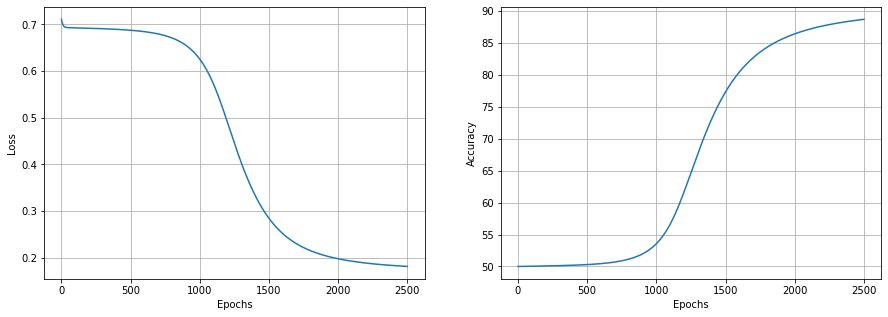

In [9]:
model.show_plot()

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100, n_features=4, n_classes=2, scale=1.0, shuffle=True, random_state=7)

In [12]:
X.shape

(100, 4)

In [13]:
y.shape

(100,)

In [14]:
y

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [15]:
model_1 = nn(lr=0.1, n_neurons=[4,3,2,1])

In [16]:
model_1.fit(X, y, epochs=3500)

Epoch  1  of  3500
Accuracy:  49.902327039430844
Loss:  0.6963105547463841
Epoch  2  of  3500
Accuracy:  49.91305033417787
Loss:  0.6958526573124136
Epoch  3  of  3500
Accuracy:  49.923160492799816
Loss:  0.6954463221108429
Epoch  4  of  3500
Accuracy:  49.9326929772605
Loss:  0.6950856653432848
Epoch  5  of  3500
Accuracy:  49.9416813235597
Loss:  0.6947654745662707
Epoch  6  of  3500
Accuracy:  49.95015721964235
Loss:  0.6944811324533987
Epoch  7  of  3500
Accuracy:  49.95815058572116
Loss:  0.6942285490747072
Epoch  8  of  3500
Accuracy:  49.96568965558465
Loss:  0.6940041017825418
Epoch  9  of  3500
Accuracy:  49.97280105777086
Loss:  0.6938045818797436
Epoch  10  of  3500
Accuracy:  49.9795098957384
Loss:  0.6936271473271549
Epoch  11  of  3500
Accuracy:  49.985839826374296
Loss:  0.6934692808227381
Epoch  12  of  3500
Accuracy:  49.99181313634592
Loss:  0.6933287526538783
Epoch  13  of  3500
Accuracy:  49.99745081594015
Loss:  0.6932035877877238
Epoch  14  of  3500
Accuracy:  50.

Accuracy:  50.15401215931834
Loss:  0.6908233324977772
Epoch  246  of  3500
Accuracy:  50.154394292362625
Loss:  0.69081548421054
Epoch  247  of  3500
Accuracy:  50.15477745368272
Loss:  0.6908076152113987
Epoch  248  of  3500
Accuracy:  50.155161648657206
Loss:  0.6907997253933086
Epoch  249  of  3500
Accuracy:  50.15554688268814
Loss:  0.6907918146487492
Epoch  250  of  3500
Accuracy:  50.155933161201254
Loss:  0.6907838828697186
Epoch  251  of  3500
Accuracy:  50.15632048964622
Loss:  0.690775929947732
Epoch  252  of  3500
Accuracy:  50.1567088734968
Loss:  0.6907679557738186
Epoch  253  of  3500
Accuracy:  50.157098318251045
Loss:  0.6907599602385175
Epoch  254  of  3500
Accuracy:  50.15748882943156
Loss:  0.6907519432318755
Epoch  255  of  3500
Accuracy:  50.157880412585655
Loss:  0.6907439046434432
Epoch  256  of  3500
Accuracy:  50.15827307328553
Loss:  0.6907358443622738
Epoch  257  of  3500
Accuracy:  50.158666817128505
Loss:  0.6907277622769163
Epoch  258  of  3500
Accuracy: 

Accuracy:  50.29209217817028
Loss:  0.6880111884587258
Epoch  486  of  3500
Accuracy:  50.292961870995256
Loss:  0.6879936076826955
Epoch  487  of  3500
Accuracy:  50.29383516914037
Loss:  0.6879759554560877
Epoch  488  of  3500
Accuracy:  50.294712092684314
Loss:  0.6879582313873062
Epoch  489  of  3500
Accuracy:  50.29559266183256
Loss:  0.6879404350823264
Epoch  490  of  3500
Accuracy:  50.296476896918364
Loss:  0.6879225661446788
Epoch  491  of  3500
Accuracy:  50.29736481840355
Loss:  0.6879046241754331
Epoch  492  of  3500
Accuracy:  50.298256446879385
Loss:  0.687886608773181
Epoch  493  of  3500
Accuracy:  50.29915180306761
Loss:  0.6878685195340181
Epoch  494  of  3500
Accuracy:  50.30005090782123
Loss:  0.6878503560515291
Epoch  495  of  3500
Accuracy:  50.300953782125504
Loss:  0.6878321179167698
Epoch  496  of  3500
Accuracy:  50.301860447098825
Loss:  0.6878138047182492
Epoch  497  of  3500
Accuracy:  50.30277092399364
Loss:  0.6877954160419122
Epoch  498  of  3500
Accurac

Epoch  735  of  3500
Accuracy:  50.70269541726319
Loss:  0.6798307627486574
Epoch  736  of  3500
Accuracy:  50.70561404102158
Loss:  0.6797733013150016
Epoch  737  of  3500
Accuracy:  50.70854866809307
Loss:  0.6797155329970274
Epoch  738  of  3500
Accuracy:  50.71149939669216
Loss:  0.679657455974494
Epoch  739  of  3500
Accuracy:  50.71446632560229
Loss:  0.6795990684173085
Epoch  740  of  3500
Accuracy:  50.717449554178174
Loss:  0.6795403684854958
Epoch  741  of  3500
Accuracy:  50.72044918234783
Loss:  0.679481354329172
Epoch  742  of  3500
Accuracy:  50.72346531061484
Loss:  0.6794220240885187
Epoch  743  of  3500
Accuracy:  50.726498040060385
Loss:  0.6793623758937537
Epoch  744  of  3500
Accuracy:  50.72954747234551
Loss:  0.6793024078651065
Epoch  745  of  3500
Accuracy:  50.73261370971324
Loss:  0.6792421181127917
Epoch  746  of  3500
Accuracy:  50.73569685499056
Loss:  0.6791815047369824
Epoch  747  of  3500
Accuracy:  50.73879701159072
Loss:  0.6791205658277868
Epoch  748  

Epoch  985  of  3500
Accuracy:  52.285085302949355
Loss:  0.6496248839551148
Epoch  986  of  3500
Accuracy:  52.29673326793398
Loss:  0.6494087899960722
Epoch  987  of  3500
Accuracy:  52.30844223158774
Loss:  0.6491916513032641
Epoch  988  of  3500
Accuracy:  52.32021245494243
Loss:  0.6489734643434707
Epoch  989  of  3500
Accuracy:  52.33204419953388
Loss:  0.6487542255877226
Epoch  990  of  3500
Accuracy:  52.34393772739618
Loss:  0.6485339315114945
Epoch  991  of  3500
Accuracy:  52.3558933010558
Loss:  0.6483125785949013
Epoch  992  of  3500
Accuracy:  52.36791118352569
Loss:  0.6480901633228973
Epoch  993  of  3500
Accuracy:  52.379991638298954
Loss:  0.6478666821854772
Epoch  994  of  3500
Accuracy:  52.39213492934249
Loss:  0.6476421316778824
Epoch  995  of  3500
Accuracy:  52.40434132109056
Loss:  0.6474165083008074
Epoch  996  of  3500
Accuracy:  52.416611078437874
Loss:  0.647189808560611
Epoch  997  of  3500
Accuracy:  52.42894446673277
Loss:  0.6469620289695304
Epoch  998 

Epoch  1235  of  3500
Accuracy:  57.72572236409099
Loss:  0.5571305229377603
Epoch  1236  of  3500
Accuracy:  57.759268056233175
Loss:  0.556606115590437
Epoch  1237  of  3500
Accuracy:  57.79290488603742
Loss:  0.5560807618322335
Epoch  1238  of  3500
Accuracy:  57.82663256103365
Loss:  0.5555544684852628
Epoch  1239  of  3500
Accuracy:  57.860450784394814
Loss:  0.5550272424061476
Epoch  1240  of  3500
Accuracy:  57.89435925496115
Loss:  0.5544990904851672
Epoch  1241  of  3500
Accuracy:  57.92835766726502
Loss:  0.5539700196453979
Epoch  1242  of  3500
Accuracy:  57.96244571155641
Loss:  0.5534400368418504
Epoch  1243  of  3500
Accuracy:  57.99662307382944
Loss:  0.5529091490605976
Epoch  1244  of  3500
Accuracy:  58.03088943584939
Loss:  0.5523773633179002
Epoch  1245  of  3500
Accuracy:  58.065244475180364
Loss:  0.551844686659327
Epoch  1246  of  3500
Accuracy:  58.099687865213994
Loss:  0.5513111261588688
Epoch  1247  of  3500
Accuracy:  58.13421927519845
Loss:  0.55077668891805

Epoch  1495  of  3500
Accuracy:  68.1873189133334
Loss:  0.4090878046122526
Epoch  1496  of  3500
Accuracy:  68.22834138018976
Loss:  0.40854432625610715
Epoch  1497  of  3500
Accuracy:  68.26932513922452
Loss:  0.4080015356667371
Epoch  1498  of  3500
Accuracy:  68.31026977955213
Loss:  0.407459437972187
Epoch  1499  of  3500
Accuracy:  68.35117489314165
Loss:  0.4069180383073291
Epoch  1500  of  3500
Accuracy:  68.39204007482955
Loss:  0.40637734181446566
Epoch  1501  of  3500
Accuracy:  68.43286492233229
Loss:  0.405837353643922
Epoch  1502  of  3500
Accuracy:  68.47364903625825
Loss:  0.40529807895462333
Epoch  1503  of  3500
Accuracy:  68.51439202011942
Loss:  0.4047595229146594
Epoch  1504  of  3500
Accuracy:  68.55509348034244
Loss:  0.4042216907018284
Epoch  1505  of  3500
Accuracy:  68.59575302627941
Loss:  0.4036845875041656
Epoch  1506  of  3500
Accuracy:  68.63637027021835
Loss:  0.4031482185204478
Epoch  1507  of  3500
Accuracy:  68.67694482739297
Loss:  0.4026125889606768

Loss:  0.30264109351716956
Epoch  1754  of  3500
Accuracy:  76.85637311674591
Loss:  0.3023673968649069
Epoch  1755  of  3500
Accuracy:  76.88133847503174
Loss:  0.3020945607279617
Epoch  1756  of  3500
Accuracy:  76.9062425589209
Loss:  0.3018225812837973
Epoch  1757  of  3500
Accuracy:  76.93108553220009
Loss:  0.3015514547138223
Epoch  1758  of  3500
Accuracy:  76.95586756002895
Loss:  0.3012811772037339
Epoch  1759  of  3500
Accuracy:  76.98058880892127
Loss:  0.3010117449438603
Epoch  1760  of  3500
Accuracy:  77.00524944672627
Loss:  0.30074315412950514
Epoch  1761  of  3500
Accuracy:  77.02984964260936
Loss:  0.3004754009612905
Epoch  1762  of  3500
Accuracy:  77.05438956703306
Loss:  0.30020848164550246
Epoch  1763  of  3500
Accuracy:  77.07886939173746
Loss:  0.29994239239443493
Epoch  1764  of  3500
Accuracy:  77.10328928972065
Loss:  0.2996771294267355
Epoch  1765  of  3500
Accuracy:  77.12764943521891
Loss:  0.2994126889677517
Epoch  1766  of  3500
Accuracy:  77.15195000368

Accuracy:  81.91429424938993
Loss:  0.25131432003156357
Epoch  2023  of  3500
Accuracy:  81.92852390538557
Loss:  0.25118811841276234
Epoch  2024  of  3500
Accuracy:  81.94272385550872
Loss:  0.25106230364694565
Epoch  2025  of  3500
Accuracy:  81.95689411848005
Loss:  0.250936874661584
Epoch  2026  of  3500
Accuracy:  81.9710347133775
Loss:  0.2508118303822591
Epoch  2027  of  3500
Accuracy:  81.98514565964338
Loss:  0.25068716973275196
Epoch  2028  of  3500
Accuracy:  81.99922697709079
Loss:  0.2505628916351295
Epoch  2029  of  3500
Accuracy:  82.01327868591002
Loss:  0.25043899500983147
Epoch  2030  of  3500
Accuracy:  82.02730080667439
Loss:  0.25031547877575544
Epoch  2031  of  3500
Accuracy:  82.04129336034572
Loss:  0.2501923418503421
Epoch  2032  of  3500
Accuracy:  82.0552563682797
Loss:  0.2500695831496589
Epoch  2033  of  3500
Accuracy:  82.0691898522306
Loss:  0.24994720158848385
Epoch  2034  of  3500
Accuracy:  82.08309383435589
Loss:  0.24982519608038772
Epoch  2035  of  

Accuracy:  84.81483099952811
Loss:  0.22794340243044572
Epoch  2294  of  3500
Accuracy:  84.82259999924952
Loss:  0.22788679240455717
Epoch  2295  of  3500
Accuracy:  84.83035205515225
Loss:  0.2278303373045406
Epoch  2296  of  3500
Accuracy:  84.83808721263193
Loss:  0.22777403660320295
Epoch  2297  of  3500
Accuracy:  84.84580551696865
Loss:  0.227717889775379
Epoch  2298  of  3500
Accuracy:  84.85350701332696
Loss:  0.22766189629792383
Epoch  2299  of  3500
Accuracy:  84.86119174675584
Loss:  0.22760605564970557
Epoch  2300  of  3500
Accuracy:  84.86885976218872
Loss:  0.2275503673115973
Epoch  2301  of  3500
Accuracy:  84.87651110444331
Loss:  0.2274948307664695
Epoch  2302  of  3500
Accuracy:  84.88414581822177
Loss:  0.22743944549918255
Epoch  2303  of  3500
Accuracy:  84.89176394811055
Loss:  0.2273842109965791
Epoch  2304  of  3500
Accuracy:  84.89936553858045
Loss:  0.2273291267474767
Epoch  2305  of  3500
Accuracy:  84.90695063398677
Loss:  0.22727419224265955
Epoch  2306  of

Accuracy:  86.34765882206797
Loss:  0.21740480297694498
Epoch  2548  of  3500
Accuracy:  86.35229302455075
Loss:  0.2173749458118346
Epoch  2549  of  3500
Accuracy:  86.35691850852572
Loss:  0.2173451574981613
Epoch  2550  of  3500
Accuracy:  86.36153529566297
Loss:  0.2173154378316019
Epoch  2551  of  3500
Accuracy:  86.36614340756823
Loss:  0.21728578660855402
Epoch  2552  of  3500
Accuracy:  86.3707428657831
Loss:  0.21725620362613296
Epoch  2553  of  3500
Accuracy:  86.37533369178516
Loss:  0.21722668868216896
Epoch  2554  of  3500
Accuracy:  86.37991590698824
Loss:  0.21719724157520395
Epoch  2555  of  3500
Accuracy:  86.38448953274273
Loss:  0.21716786210448924
Epoch  2556  of  3500
Accuracy:  86.38905459033548
Loss:  0.21713855006998217
Epoch  2557  of  3500
Accuracy:  86.39361110099038
Loss:  0.21710930527234354
Epoch  2558  of  3500
Accuracy:  86.3981590858683
Loss:  0.21708012751293446
Epoch  2559  of  3500
Accuracy:  86.40269856606734
Loss:  0.21705101659381412
Epoch  2560  

Accuracy:  87.31445584145104
Loss:  0.21146215899776377
Epoch  2809  of  3500
Accuracy:  87.31739485199901
Loss:  0.21144500482132764
Epoch  2810  of  3500
Accuracy:  87.32032911762084
Loss:  0.21142788405060398
Epoch  2811  of  3500
Accuracy:  87.32325864863337
Loss:  0.21141079659933737
Epoch  2812  of  3500
Accuracy:  87.32618345532563
Loss:  0.21139374238153774
Epoch  2813  of  3500
Accuracy:  87.32910354795922
Loss:  0.21137672131147947
Epoch  2814  of  3500
Accuracy:  87.332018936768
Loss:  0.21135973330370056
Epoch  2815  of  3500
Accuracy:  87.33492963195852
Loss:  0.21134277827300124
Epoch  2816  of  3500
Accuracy:  87.33783564370982
Loss:  0.21132585613444366
Epoch  2817  of  3500
Accuracy:  87.34073698217381
Loss:  0.21130896680335037
Epoch  2818  of  3500
Accuracy:  87.34363365747495
Loss:  0.21129211019530392
Epoch  2819  of  3500
Accuracy:  87.34652567971085
Loss:  0.2112752862261454
Epoch  2820  of  3500
Accuracy:  87.34941305895194
Loss:  0.21125849481197384
Epoch  2821

Epoch  3081  of  3500
Accuracy:  87.9698774706315
Loss:  0.20778031203990635
Epoch  3082  of  3500
Accuracy:  87.97182772362977
Loss:  0.20776978826085404
Epoch  3083  of  3500
Accuracy:  87.97377525378747
Loss:  0.20775928169421562
Epoch  3084  of  3500
Accuracy:  87.9757200662766
Loss:  0.20774879230062696
Epoch  3085  of  3500
Accuracy:  87.97766216625696
Loss:  0.2077383200408292
Epoch  3086  of  3500
Accuracy:  87.9796015588761
Loss:  0.20772786487566833
Epoch  3087  of  3500
Accuracy:  87.98153824926935
Loss:  0.2077174267660947
Epoch  3088  of  3500
Accuracy:  87.98347224255997
Loss:  0.2077070056731631
Epoch  3089  of  3500
Accuracy:  87.985403543859
Loss:  0.20769660155803174
Epoch  3090  of  3500
Accuracy:  87.9873321582654
Loss:  0.20768621438196253
Epoch  3091  of  3500
Accuracy:  87.9892580908661
Loss:  0.20767584410632067
Epoch  3092  of  3500
Accuracy:  87.99118134673604
Loss:  0.20766549069257395
Epoch  3093  of  3500
Accuracy:  87.99310193093812
Loss:  0.20765515410229

Epoch  3326  of  3500
Accuracy:  88.37724583295902
Loss:  0.20563449956302526
Epoch  3327  of  3500
Accuracy:  88.37865827453899
Loss:  0.20562722911060582
Epoch  3328  of  3500
Accuracy:  88.38006896378297
Loss:  0.2056199687065569
Epoch  3329  of  3500
Accuracy:  88.38147790367219
Loss:  0.20561271832960715
Epoch  3330  of  3500
Accuracy:  88.3828850971814
Loss:  0.2056054779585352
Epoch  3331  of  3500
Accuracy:  88.38429054727905
Loss:  0.20559824757216966
Epoch  3332  of  3500
Accuracy:  88.38569425692737
Loss:  0.2055910271493887
Epoch  3333  of  3500
Accuracy:  88.38709622908218
Loss:  0.20558381666911996
Epoch  3334  of  3500
Accuracy:  88.3884964666931
Loss:  0.20557661611034064
Epoch  3335  of  3500
Accuracy:  88.38989497270344
Loss:  0.20556942545207726
Epoch  3336  of  3500
Accuracy:  88.39129175005037
Loss:  0.20556224467340534
Epoch  3337  of  3500
Accuracy:  88.39268680166468
Loss:  0.2055550737534493
Epoch  3338  of  3500
Accuracy:  88.39408013047107
Loss:  0.2055479126

Model Performance Plots


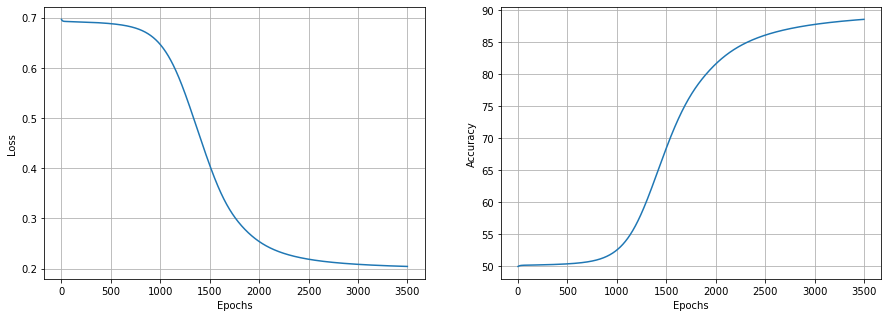

In [17]:
model_1.show_plot()